# Predicting the Length of Ramadan using Historical Data (1940 - 2024)

## Project Overview / Objective

This project aims to predict the length of Ramadan—whether it will last **29 or 30 days**—based on historical Islamic calendar data.

The Islamic (Hijri) calendar is lunar-based, and the length of Ramadan can vary each year. Accurate predictions of Ramadan’s length can help with:

- Religious planning and scheduling
- Public and private sector logistics
- Community and national preparation for Eid celebrations

**Machine Learning Task Involved:**
- **Classification**: Predicting `Ramadan_Length` (29 or 30 days) as a binary outcome.

**Expected Outcome:**
- A trained machine learning model that uses historical Hijri and Gregorian calendar data to forecast whether a given Ramadan will span 29 or 30 days.
- A better understanding of the patterns that influence the variability in Ramadan's length.


## Problem Description

The Islamic calendar follows a lunar cycle, meaning each month lasts either 29 or 30 days, depending on moon sighting. Ramadan, being one of the most significant months for Muslims, can end on the 29th or 30th day. This variability makes precise planning difficult for individuals, organizations, and governments alike.

While religious moon sighting remains the traditional method, this project explores whether historical calendar patterns and month-length behaviors can help **predict the length of Ramadan** using machine learning.

**Why This Problem Is Worth Solving:**
- **Religious Planning**: Accurate predictions can assist in preparing for Eid celebrations, mosque logistics, and prayer schedules.
- **Public Services**: Governments and schools can plan holidays and public announcements more effectively.
- **General Preparedness**: Families and businesses can better prepare for the end of Ramadan and start of Shawwal.

**Who Benefits:**
- Religious communities and clerics
- Event and logistics planners
- Government/public service providers
- Curious individuals interested in calendar prediction

**Real-World Implication:**
Even if moon sighting is the final determinant, having a **data-driven estimate** provides a useful planning tool and opens up new ways to understand historical lunar month trends.


## Module Imports

All necessary python libraries for dta collection, cleaning, analysis, modelling, and evaluation are imported

In [1]:
# General Utilities 
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 10,6
import seaborn as sns

# Data Preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,  confusion_matrix, ConfusionMatrixDisplay

# machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Web Scraping
import requests
from bs4 import BeautifulSoup
import os

## Data Collection and Cleaning

To predict the length of Ramadan, I collected historical data from two trusted sources:

1. **Wikipedia** – Provided a summary table of historical Ramadan start and end dates, including Gregorian and Hijri years.
2. **Hijri.Habibur.com** – An Islamic calendar site offering detailed monthly breakdowns for each Hijri year, including the number of days in each month.

### Tools Used:
- `requests` – For sending HTTP requests and retrieving HTML content.
- `BeautifulSoup` – For parsing HTML content.
- `pandas` – For storing and manipulating the scraped data.

### Strategy:
- **Wikipedia**: Since all the relevant information was in a single table, I scraped it in one go and parsed it into a DataFrame.
- **Hijri.Habibur**: Each Hijri year had a dedicated page, so I looped over the years 1359 AH (≈1940) to 1445 AH (≈2024), fetching the month-length data year by year and compiling it into a second DataFrame.

These two sources were then cleaned and merged during the preprocessing stage to create a unified dataset containing:

- Hijri Year
- Gregorian Year
- Ramadan Start Month and Day
- Length of Sha'ban
- Length of Ramadan (Target Variable)

This historical dataset forms the foundation of the prediction task.


In [2]:
filename = 'data/Ramadan_Length_Prediction_data.csv'

In [3]:
# Check if code already processed to prevent repetitive scraping
if os.path.exists(filename):
        print("Reading from saved file...")
        df = pd.read_csv(filename)

# If not, then scrape and clean the Data
else:
    # Scarping from Wikipedia
    url = "https://en.wikipedia.org/wiki/Template:Ramadan_dates"

    response = requests.get(url)
    wiki_webpage = response.text

    soup = BeautifulSoup(wiki_webpage, "html.parser")

    table = soup.find('table', class_ = 'wikitable')
    rows = table.find_all('tr')
    start_date_list = []
    hijri_year = []

    for i in [0,2,4,6]:
        for row in rows:
            cols = row.find_all('td')
            if len(cols) > i:
                if i < len(cols):
                    date_text = cols[i].text.strip()

                    start_date_list.append(date_text)
                    
    for i in [1,3,5,7]:
        for row in rows:
            cols = row.find_all('td')
            if len(cols) > i:
                if i < len(cols):
                    hijri_date = int(cols[i].text.strip())

                    hijri_year.append(hijri_date)

    data = {'Ramadan_Start': start_date_list,
            'Hijri_Year': hijri_year}
    # Save scraped data(Ramadan Start date and the Hijri Year)
    df1 = pd.DataFrame(data)
    
    # Scrape from the islamic calender website Hijri.habibur
    years = list(range(1359, 1446))

    month_length_list = []

    for year in years:
        url = f"https://hijri.habibur.com/{year}/"

        response = requests.get(url)
        hijri_webpage = response.text

        soup = BeautifulSoup(hijri_webpage, "html.parser")
        
        table = soup.find('table', class_='data')
        rows = table.find_all('tr')
        
        ramadan_length = None
        shaban_length = None
        
        for row in rows:
            cols = row.find_all('td')
            if len(cols) >= 3:
                month_name = cols[0].text.strip()
                days = cols[3].text.strip()
                
                if month_name.lower() == f'ramadan {year}':
                    ramadan_length = days
                elif month_name.lower() == f'shaban {year}':
                    shaban_length = days
                
        if shaban_length and ramadan_length:    
            month_length_list.append({'Hijri_Year': year,
                                    "Sha'ban_Length": shaban_length,
                                    "Ramadan_Length": ramadan_length})
            # Save scraped data (Hijri Year, Length of Shaban and the Length of Ramadan for the scraped Hijri Year)
        df2 = pd.DataFrame(month_length_list)
        
    # Clean the scraped data
    df1['Ramadan_Start'] = pd.to_datetime(df1['Ramadan_Start'])

    df1['Year'] = df1['Ramadan_Start'].dt.year
    df1['Start_Month'] = df1['Ramadan_Start'].dt.month
    df1['Start_Day'] = df1['Ramadan_Start'].dt.day
    df1 = df1.drop(columns='Ramadan_Start')
    df1 = df1.query('Year > 1939 and Year < 2025')
    df2['Sha\'ban_Length'] = df2["Sha\'ban_Length"].str.extract('(\d+)')
    df2['Ramadan_Length'] = df2["Ramadan_Length"].str.extract('(\d+)')

    df2['Ramadan_Length'] = pd.to_numeric(df2['Ramadan_Length'])
    df2['Sha\'ban_Length'] = pd.to_numeric(df2['Sha\'ban_Length'])
    
    # Merge the two Dataframe to one and then save toa csv file
    df = pd.merge(df1, df2, on='Hijri_Year', how='inner')
    df.to_csv(filename, index=False)
    print('Scraping and cleaning complete.')

Reading from saved file...


In [4]:
df.tail()

,Hijri_Year,Year,Start_Month,Start_Day,Sha'ban_Length,Ramadan_Length
82,1441,2020,4,24,29,30
83,1442,2021,4,13,29,30
84,1443,2022,4,2,29,30
85,1444,2023,3,23,29,29
86,1445,2024,3,11,30,29


## Exploratory Data Analysis (EDA)

Before diving into modeling, I explored the dataset to understand the distributions, relationships, and patterns in the data.

### Dataset Overview:
- Used `.info()` and `.describe()` to inspect the dataset’s structure, datatypes, and basic statistics.
- Confirmed all expected columns were present and contained valid data across the years.

### Visual Exploration:

1. **Distribution of Ramadan and Sha'ban Lengths (1940–2024)**  
   - Bar charts were used to show the frequency of each possible length (29 or 30 days).
   - These visuals revealed that both Ramadan and Sha'ban frequently alternate between 29 and 30 days.

2. **Correlation Analysis**  
   - A heatmap was plotted to examine the relationship between Sha'ban length and Ramadan length.
   - Found a good correlation, suggesting Ramadan's length may be directly influenced by the preceding month.

3. **Temporal Trends**  
   - A line graph illustrated how the lengths of Sha'ban and Ramadan have varied over the years.
   - Another heatmap and boxplot explored how the **start month** of Ramadan relates to its length.
   - A line plot visualized how the **start month** of Ramadan has shifted over time, highlighting the lunar cycle's effect.

4. **Anomaly Detection**  
   - Two years, **1965** and **1997**, were flagged for anomalies—these years appeared to have **two Ramadans**.
   - Used `duplicated()` to confirm there were indeed two Ramadan in a Gregorian Year(January and December).
   - Displayed these anomalies for reference and preserved them in the dataset for completeness.

5. **Ramadan Start Day Analysis**  
   - A horizontal bar chart displayed how often Ramadan begins on each day of the Gregorian month (1–31).
   - A line chart showed the trend of Ramadan's starting **day** across years, revealing no fixed pattern due to the lunar cycle.

Overall, the EDA provided important context that helped shape feature selection and informed decisions during feature engineering and modeling.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Hijri_Year      87 non-null     int64
 1   Year            87 non-null     int64
 2   Start_Month     87 non-null     int64
 3   Start_Day       87 non-null     int64
 4   Sha'ban_Length  87 non-null     int64
 5   Ramadan_Length  87 non-null     int64
dtypes: int64(6)
memory usage: 4.2 KB


In [6]:
df.describe()

,Hijri_Year,Year,Start_Month,Start_Day,Sha'ban_Length,Ramadan_Length
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000
mean,1402.000000,1981.977011,6.528736,15.356322,29.482759,29.505747
std,25.258662,24.514816,3.198252,8.882930,0.502599,0.502865
min,1359.000000,1940.000000,1.000000,1.000000,29.000000,29.000000
25%,1380.500000,1961.500000,4.000000,7.500000,29.000000,29.000000
50%,1402.000000,1982.000000,6.000000,16.000000,29.000000,30.000000
75%,1423.500000,2002.500000,9.000000,23.500000,30.000000,30.000000
max,1445.000000,2024.000000,12.000000,31.000000,30.000000,30.000000


Ramadan Lengths and their Frequency
30 Days : 44
29 Days : 43


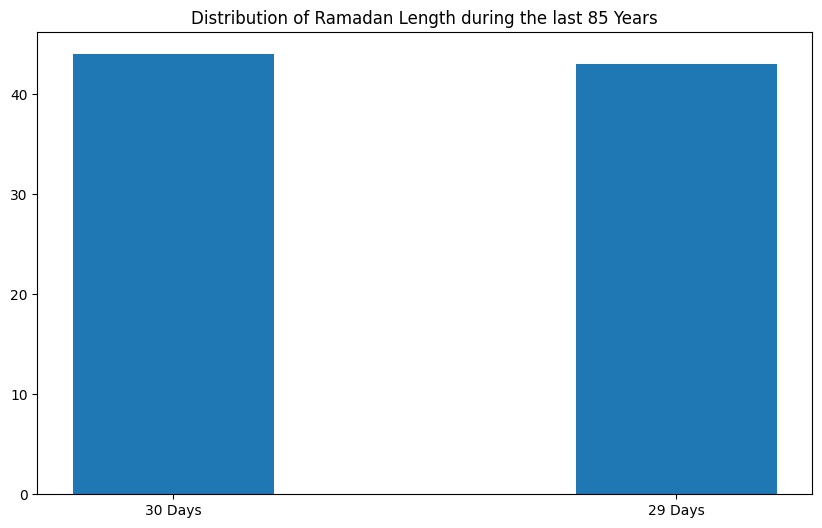

In [7]:
ramadan_length = df['Ramadan_Length'].value_counts()
print('Ramadan Lengths and their Frequency')
print(f"30 Days : {ramadan_length.values[0]}\n29 Days : {ramadan_length.values[1]}")
plt.title("Distribution of Ramadan Length during the last 85 Years")
label = ["30 Days", "29 Days"]
plt.bar(label, ramadan_length.values, width=0.4)
plt.show()

Shaban Lengths and their frequency
29 Days : 45
30 Days : 42


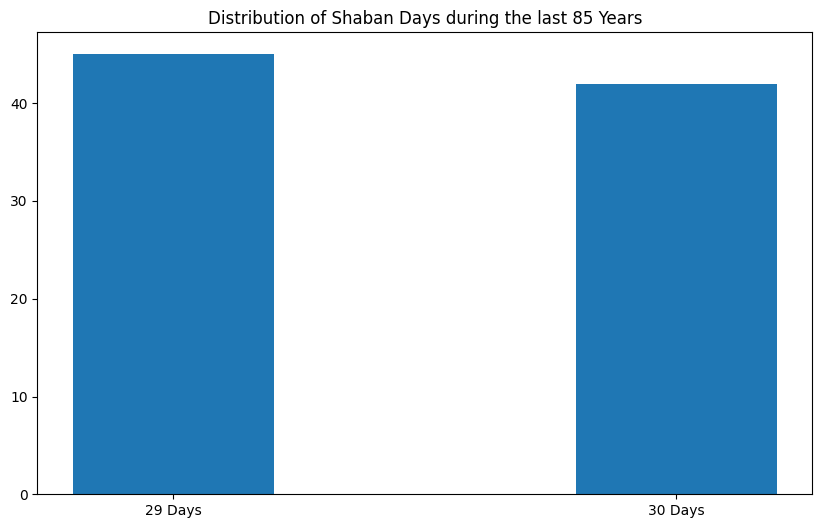

In [8]:
shaban_length = df['Sha\'ban_Length'].value_counts()
print('Shaban Lengths and their frequency')
print(f"29 Days : {shaban_length.values[0]}\n30 Days : {shaban_length.values[1]}")
plt.title("Distribution of Shaban Days during the last 85 Years")
label = ["29 Days", "30 Days"]
plt.bar(label, shaban_length.values, width=0.4)
plt.show()

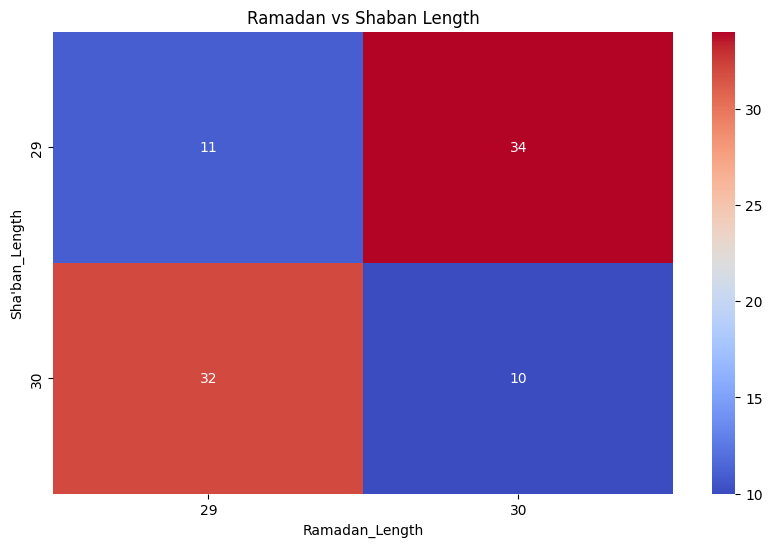

In [9]:
plt.title('Ramadan vs Shaban Length')
plt.xlabel('Shaban Length')
plt.ylabel('Ramadan Length')

heat_data = pd.crosstab(df['Sha\'ban_Length'], df['Ramadan_Length'])
sns.heatmap(heat_data, annot=True, cmap='coolwarm')
plt.show()

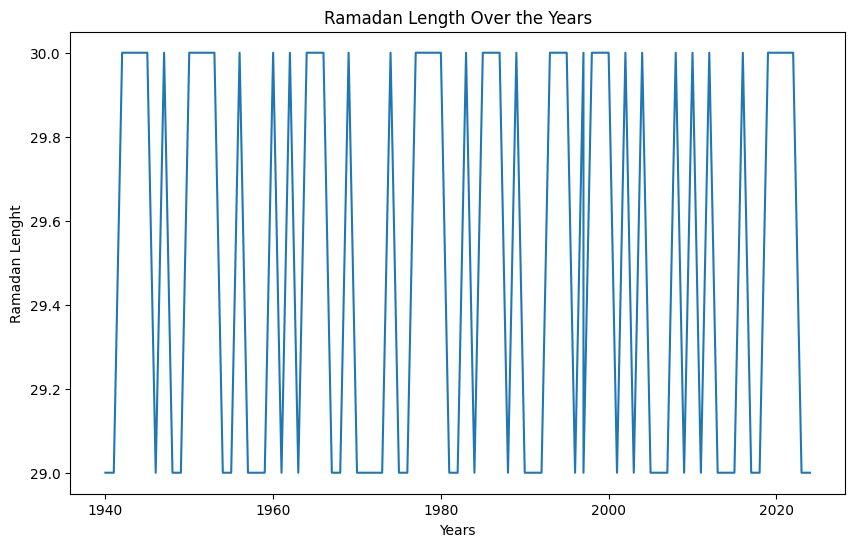

In [10]:
plt.title('Ramadan Length Over the Years')
plt.xlabel('Years')
plt.ylabel('Ramadan Lenght')
plt.plot(df['Year'], df['Ramadan_Length'])
plt.show()

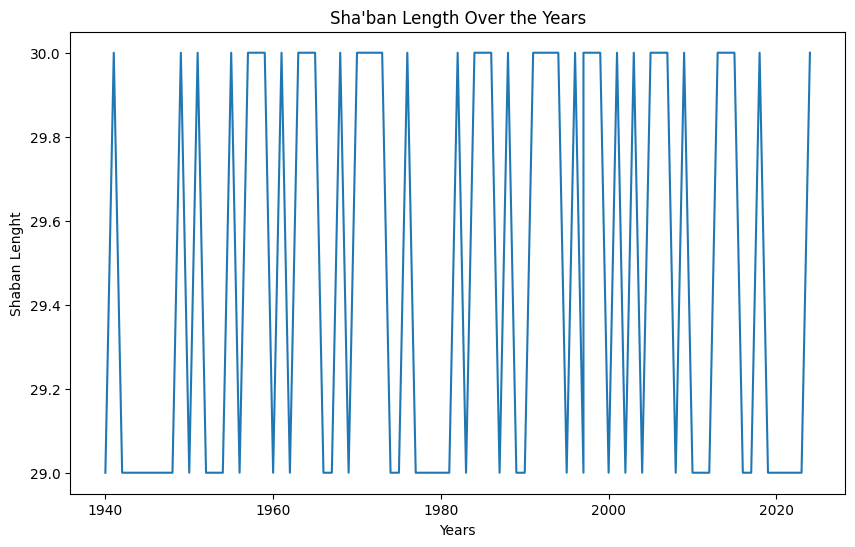

In [11]:
plt.title('Sha\'ban Length Over the Years')
plt.xlabel('Years')
plt.ylabel('Shaban Lenght')
plt.plot(df['Year'], df['Sha\'ban_Length'])
plt.show()

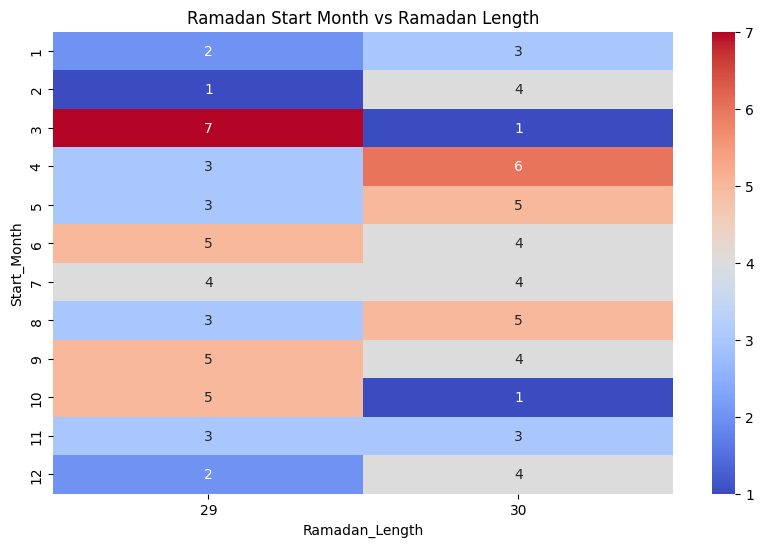

In [12]:
plt.title('Ramadan Start Month vs Ramadan Length')
plt.xlabel('Start Month')
plt.ylabel('Ramadan Length')

heat_data = pd.crosstab(df['Start_Month'], df['Ramadan_Length'])
sns.heatmap(heat_data, annot=True, cmap='coolwarm')
plt.show()

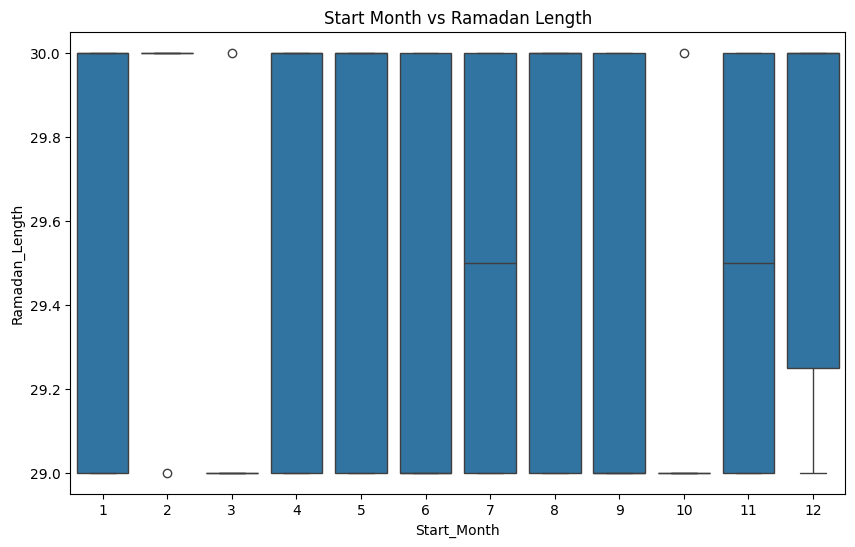

In [13]:
plt.title("Start Month vs Ramadan Length")

with sns.axes_style('whitegrid'):
    ax = sns.boxplot(x=df['Start_Month'], y=df['Ramadan_Length'])
plt.show()

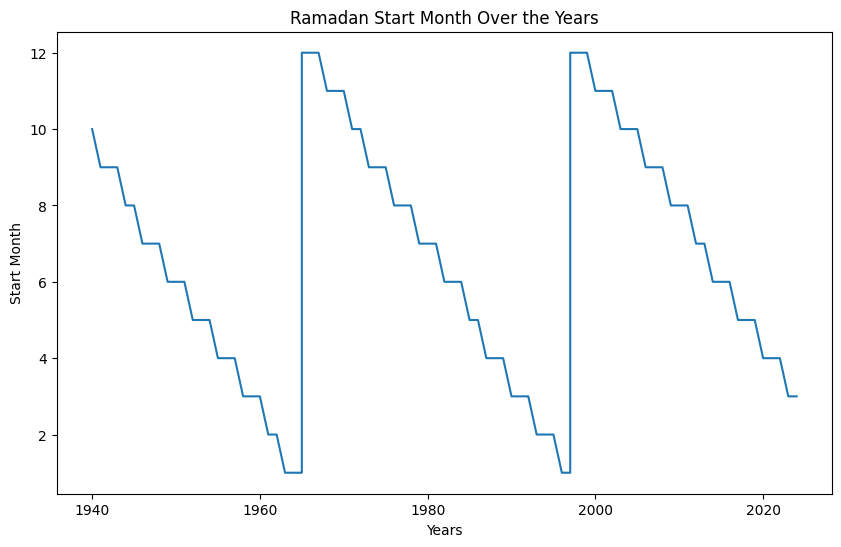

In [14]:
plt.title('Ramadan Start Month Over the Years')
plt.xlabel('Years')
plt.ylabel('Start Month')
plt.plot(df['Year'], df['Start_Month'])
plt.show()

In [15]:
df[df.duplicated('Year', keep=False)]

,Hijri_Year,Year,Start_Month,Start_Day,Sha'ban_Length,Ramadan_Length
25,1384,1965,1,6,30,30
26,1385,1965,12,27,30,30
58,1417,1997,1,10,29,30
59,1418,1997,12,31,30,29


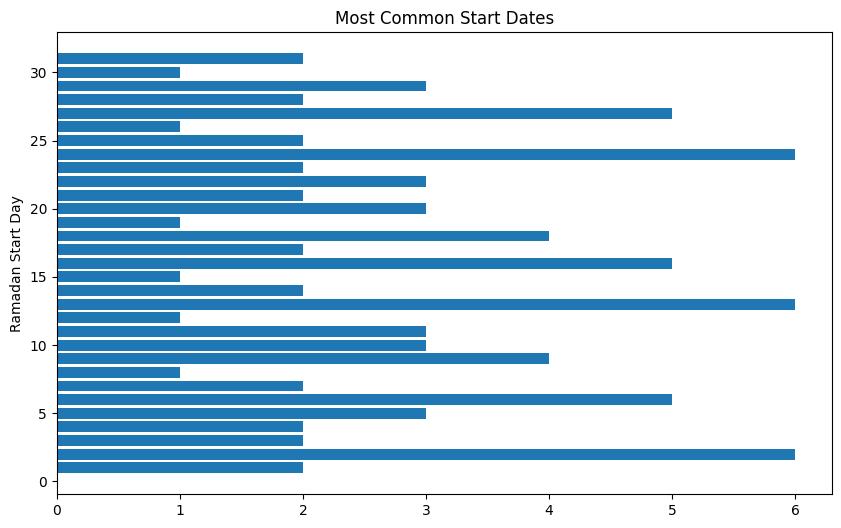

In [16]:
start_day = df['Start_Day'].value_counts().sort_index()

plt.title('Most Common Start Dates')
plt.ylabel('Ramadan Start Day')
plt.barh(start_day.index, start_day.values)
plt.show()

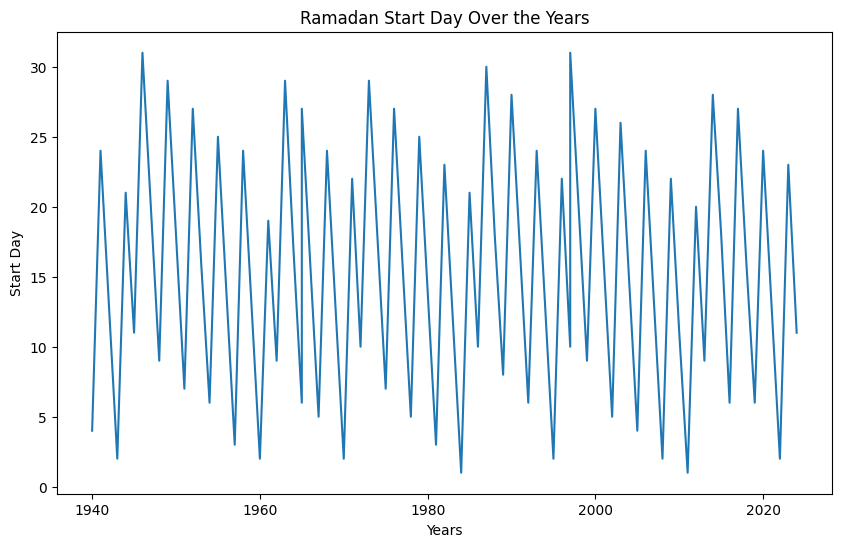

In [17]:
plt.title('Ramadan Start Day Over the Years')
plt.xlabel('Years')
plt.ylabel('Start Day')
plt.plot(df['Year'], df['Start_Day'])
plt.show()

## Feature Engineering

To prepare the data for modeling, several transformation and preprocessing steps were performed:

### 1. Multicollinearity Check:
- A heatmap was used to assess correlation between numerical features.
- It was discovered that the **Hijri Year** and **Gregorian Year** were highly correlated, which could introduce multicollinearity into the model.
- To prevent this redundancy, the **Hijri Year** column was dropped.

### 2. Target Encoding:
- The target variable, `Ramadan_Length`, originally had values of 29 and 30.
- These were encoded as:
  - **1** for 29-day Ramadans
  - **0** for 30-day Ramadans  
This binary transformation simplifies the classification task and aligns with common machine learning practices.

### 3. Data Splitting:
- The dataset was split into **training** and **testing** sets to evaluate the model's generalization performance.

### 4. Feature Scaling:
- `StandardScaler` was applied to standardize the feature values.
- This scaling ensures that all input features contribute equally during model training and prevents bias toward variables with larger ranges.

These preprocessing steps ensured the dataset was clean, well-structured, and ready for efficient modeling.


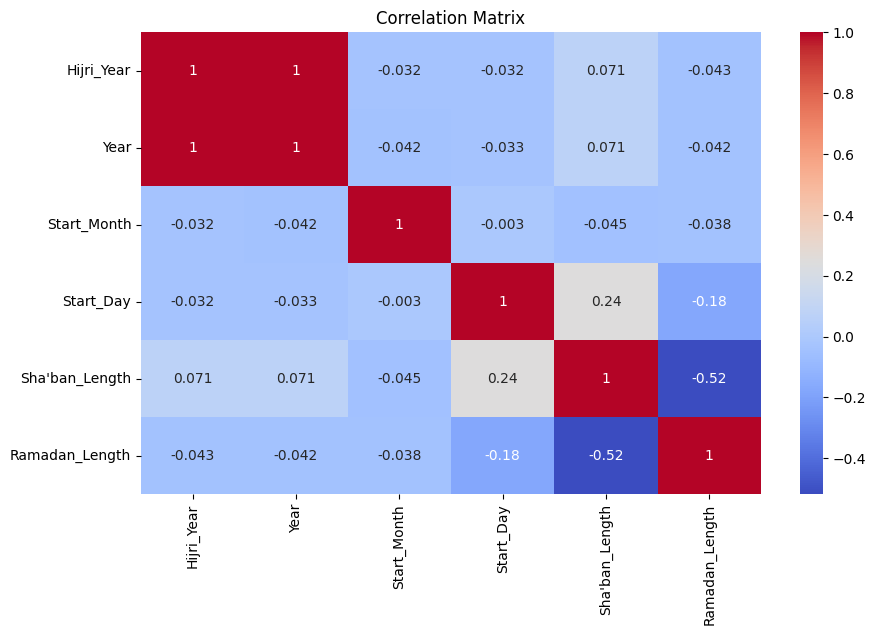

In [18]:
correlation_matrix = df.corr()

plt.title('Correlation Matrix')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

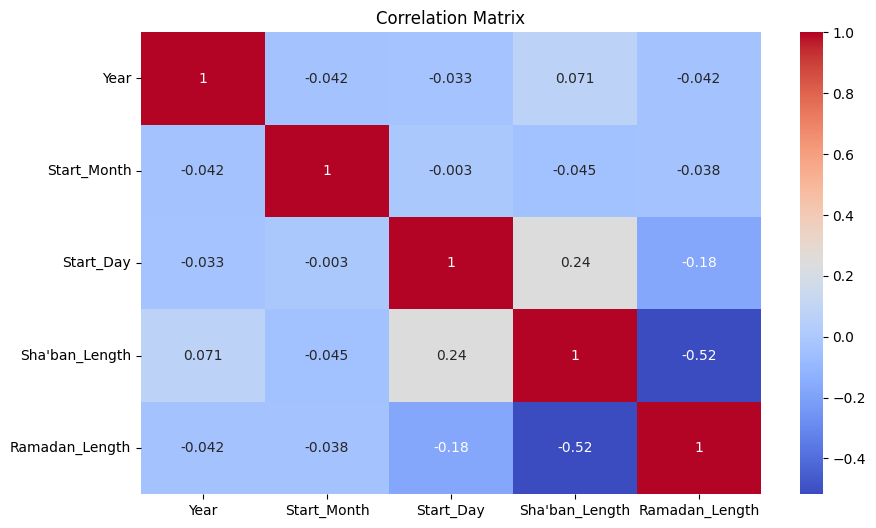

In [19]:
df = df.drop(columns='Hijri_Year')
correlation_matrix = df.corr()

plt.title('Correlation Matrix')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [20]:
df['Ramadan_Length'] = np.where(df['Ramadan_Length'] == 29, 1, 0)
df.sample(2)

,Year,Start_Month,Start_Day,Sha'ban_Length,Ramadan_Length
43,1982,6,23,30,1
23,1963,1,29,30,1


In [21]:
target = df['Ramadan_Length']
features = df.drop(columns='Ramadan_Length', axis=1)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2, 
                                                    random_state=10)

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

## Modeling

To predict whether a Ramadan will last **29 or 30 days**, several classification models were evaluated:

### Models Used:
1. **Logistic Regression**
2. **Decision Tree Classifier**
3. **Random Forest Classifier**
4. **Gradient Boosting Classifier**
5. **XGBoost Classifier**

Each model was trained on the training set and evaluated on the test set using the following classification metrics:
- **Accuracy**: Overall correctness of the model
- **F1 Score**: Harmonic mean of precision and recall
- **ROC-AUC Score**: Measures the ability of the model to distinguish between the classes

### Performance Summary:

| Model                 | Accuracy (%) | F1 Score (%) | ROC-AUC (%) |
|----------------------|--------------|--------------|-------------|
| Logistic Regression  | 61           | 63           | 61          |
| Decision Tree        | 56           | 56           | 56          |
| Random Forest        | 44           | 50           | 44          |
| Gradient Boosting    | 50           | 53           | 50          |
| XGBoost              | 44           | 50           | 44          |

### Observations:
- **Logistic Regression** performed the best among all models with a balanced performance across all metrics.
- Tree-based models struggled more, possibly due to overfitting or limited signal in the features.
- As a result, **Logistic Regression** was chosen as the final model for predictions.

 

In [24]:
logistic_regression = LogisticRegression()
logistic_regression.fit(X_train_scaled, y_train)

# Model Evaluation

y_pred = logistic_regression.predict(X_test_scaled) 

accuracy = round(accuracy_score(y_test, y_pred) * 100)
f1 = round(f1_score(y_test, y_pred) * 100)
roc_auc = round(roc_auc_score(y_test, y_pred) * 100)

print(f"Accuracy: {accuracy}")
print("f1 Score: ", f1)
print("ROC-AUC Score: ", roc_auc)

Accuracy: 61
f1 Score:  63
ROC-AUC Score:  61


In [25]:
decision_tree = DecisionTreeClassifier(max_depth=3, random_state=10)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

accuracy = round(accuracy_score(y_test, y_pred) * 100)
f1 = round(f1_score(y_test, y_pred) * 100)
roc_auc = round(roc_auc_score(y_test, y_pred) * 100)
    
print(f"Accuracy: {accuracy}")
print("f1 Score: ", f1)
print("ROC-AUC Score: ", roc_auc)

Accuracy: 56
f1 Score:  56
ROC-AUC Score:  56


In [26]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=10)
random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

accuracy = round(accuracy_score(y_test, y_pred) * 100)
f1 = round(f1_score(y_test, y_pred) * 100)
roc_auc = round(roc_auc_score(y_test, y_pred) * 100)

print(f"Accuracy: {accuracy}")
print("f1 Score: ", f1)
print("ROC-AUC Score: ", roc_auc)

Accuracy: 44
f1 Score:  50
ROC-AUC Score:  44


In [27]:
gradient_boosting = GradientBoostingClassifier(n_estimators=100,
                                               learning_rate=0.1, 
                                               max_depth=3, 
                                               random_state=10)
gradient_boosting.fit(X_train, y_train)

y_pred = gradient_boosting.predict(X_test)

accuracy = round(accuracy_score(y_test, y_pred) * 100)
f1 = round(f1_score(y_test, y_pred) * 100)
roc_auc = round(roc_auc_score(y_test, y_pred) * 100)

print(f"Accuracy: {accuracy}")
print("f1 Score: ", f1)
print("ROC-AUC Score: ", roc_auc)

Accuracy: 50
f1 Score:  53
ROC-AUC Score:  50


In [28]:
xg_boost = XGBClassifier(n_estimators=100,
                        learning_rate=0.1, 
                        max_depth=3, 
                        random_state=10)
xg_boost.fit(X_train, y_train)

y_pred = xg_boost.predict(X_test)

accuracy = round(accuracy_score(y_test, y_pred) * 100)
f1 = round(f1_score(y_test, y_pred) * 100)
roc_auc = round(roc_auc_score(y_test, y_pred) * 100)

print(f"Accuracy: {accuracy}")
print("f1 Score: ", f1)
print("ROC-AUC Score: ", roc_auc)

Accuracy: 44
f1 Score:  50
ROC-AUC Score:  44


## Model Evaluation

To assess the final model’s performance beyond metrics, a **confusion matrix** was used for a clearer picture of the model’s predictions:

### Confusion Matrix:

|                      | Predicted: 29 Days | Predicted: 30 Days |
|----------------------|--------------------|--------------------|
| **Actual: 29 Days**  | 6                  | 3                  |
| **Actual: 30 Days**  | 4                  | 5                  |

### Interpretation:
- The model correctly predicted **6 out of 9** instances of 29-day Ramadan.
- It also predicted **4 out of 9** instances of 30-day Ramadan correctly.
- Misclassifications are balanced, with a slight tendency to predict 29 days more often.

Despite the relatively small sample size for evaluation, the confusion matrix supports the selection of **Logistic Regression** as the final model based on its better generalization compared to other models.



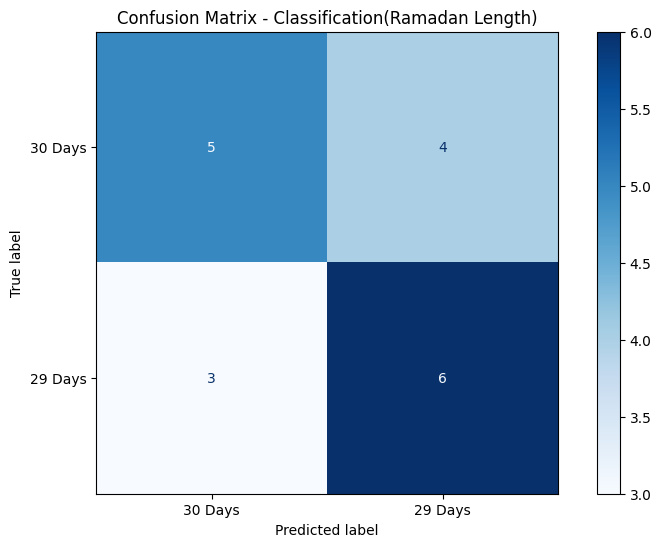

In [29]:
y_pred = logistic_regression.predict(X_test_scaled)
 
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['30 Days', '29 Days'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Classification(Ramadan Length)")
plt.show()

## Predictions

To test the final model, a `prediction_df` was created with sample inputs representing the year 2025 Ramadan starting conditions. The model then predicted whether Ramadan would last **29 or 30 days**.

The prediction output was formatted to be easily interpretable using an `if` statement. For instance, if the model predicted `0`, it would be interpreted as **30 days**, and if it predicted `1`, it would be **29 days**.

### Example Output:
> **"The Ramadan for [inserted year] will last for 29 days."**

This format ensures clarity and readability of the prediction, making the output user-friendly for non-technical audiences.


In [30]:
average_vals = features.mean().values

prediction_df = pd.DataFrame(data= average_vals.reshape(1, len(features.columns)), columns=features.columns)

prediction_df['Year'] = 2025
prediction_df['Sha\'ban_Length'] = 29
prediction_df['Start_Month'] = 3
prediction_df['Start_Day'] = 1

ramadan_length = logistic_regression.predict(prediction_df)[0]

if ramadan_length == 0:
    length = 30
elif ramadan_length == 1:
    length = 29
print(f'The Ramadan for {prediction_df["Year"][0]} will last for {length} days')

The Ramadan for 2025 will last for 29 days


c:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


## Conclusion & Next Steps

### Summary of Findings
This project successfully built a classification model to predict whether Ramadan would last **29 or 30 days** using historical data from **1940 to 2024**. Through careful feature analysis and model evaluation, it was found that **Logistic Regression** performed best with reasonable predictive power compared to more complex models.

### Real-world Implications
Understanding the likely duration of Ramadan ahead of time can be beneficial for planning in many aspects, such as:
- Religious and cultural event scheduling
- Food supply planning
- Government and institutional calendar alignment

While traditional moon sightings are the standard, a data-driven approach could offer supportive insights.

### Limitations
- The dataset is relatively small and only covers 85 years, which limits generalizability.
- External astronomical factors and regional moon sightings aren't directly accounted for.
- The dataset contains years with two Ramadans (e.g., 1965 and 1997), which are rare anomalies and may affect model behavior.


### Future Work
- The model will be deployed as a **web-based service** or script running on platforms like **PythonAnywhere** that can email daily or monthly predictions.
- Eventually, integrate live astronomical data to improve the model's real-time reliability.


## **Appendix / References**

- [Wikipedia Ramadan Dates Template Page](https://weather.visualcrossing.com)
- [Hijri.habibur Webpage](https://hijri.habibur.com)
- [Scikit-learn Documentation](https://scikit-learn.org/stable/)
- [Pandas Documentation](https://pandas.pydata.org/docs/)
- [XGBoost Documentation](https://xgboost.readthedocs.io/en/stable/)
- [Matplotlib Documentation](https://matplotlib.org/stable/)
- [Seaborn Documentation](https://seaborn.pydata.org/)

---